In [36]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

from helper_funcs import *

In [13]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 43)

In [15]:
zipdata.loc[zipdata.over_65_ratio.isna(),'over_65_ratio'] = 0
zipdata.loc[zipdata.Hosp_count.isna(),'Hosp_count'] = 0
zipdata.loc[zipdata.HPI.isna(),'HPI'] = 0
zipdata.loc[zipdata.Demand_score.isna(),'Demand_score'] = 0
zipdata.loc[zipdata.Supply_score.isna(),'Supply_score'] = 0
zipdata.loc[zipdata.listviews_vs_US.isna(),'listviews_vs_US'] = 0
zipdata.loc[zipdata.med_days_on_mkt.isna(),'med_days_on_mkt'] = 0
zipdata.loc[zipdata.nielson_rank.isna(),'nielson_rank'] = 0
zipdata.loc[zipdata.Zillow_HVF.isna(),'Zillow_HVF'] = 0

In [16]:
zipdata.loc[zipdata.school_rating.isna(),'school_rating'] = 5
zipdata.loc[zipdata.UE_rate.isna(),'UE_rate'] = zipdata.UE_rate.mean()
zipdata.loc[zipdata.BEA_percap_income.isna(),'BEA_percap_income'] = zipdata.BEA_percap_income.mean()

In [17]:
zipdata.drop(columns=zipdata.columns[-12:], inplace=True)
zipdata.drop(columns=zipdata.columns[:5], inplace=True)

In [18]:
zipdata['Blacks_ratio'] = zipdata.BlackPopulation / zipdata.Population
zipdata['Hispanics_ratio'] = zipdata.HispanicPopulation / zipdata.Population
zipdata['Asians_ratio'] = zipdata.AsianPopulation / zipdata.Population
zipdata['Indians_ratio'] = zipdata.IndianPopulation / zipdata.Population
zipdata['Others_ratio'] = zipdata.OtherPopulation / zipdata.Population
zipdata['Male_ratio'] = zipdata.MalePopulation / zipdata.Population
zipdata.loc[zipdata.Blacks_ratio.isna(),'Blacks_ratio'] = 0
zipdata.loc[zipdata.Hispanics_ratio.isna(),'Hispanics_ratio'] = 0
zipdata.loc[zipdata.Asians_ratio.isna(),'Asians_ratio'] = 0
zipdata.loc[zipdata.Indians_ratio.isna(),'Indians_ratio'] = 0
zipdata.loc[zipdata.Others_ratio.isna(),'Others_ratio'] = 0
zipdata.loc[zipdata.Male_ratio.isna(),'Male_ratio'] = 0

zipdata.drop(columns=['BlackPopulation','HispanicPopulation','AsianPopulation','WhitePopulation',
                      'IndianPopulation','OtherPopulation','MalePopulation','FemalePopulation'], inplace=True)

In [19]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
BEA_percap_income       0
Blacks_ratio            0
Hispanics_ratio         0
Asians_ratio            0
Indians_ratio           0
Others_ratio            0
Male_ratio              0
dtype: int64

### 🎚️ Scale data before clustering

In [21]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.values), 
                           columns=zipdata.columns, 
                           index=zipdata.index)

In [22]:
data_scaled.columns

Index(['Population', 'HouseholdsPerZipCode', 'AverageHouseValue',
       'IncomePerHousehold', 'MedianAge', 'NumberOfBusinesses',
       'over_65_ratio', 'school_rating', 'Hosp_count', 'HPI', 'Demand_score',
       'Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank',
       'UE_rate', 'Zillow_HVF', 'BEA_percap_income', 'Blacks_ratio',
       'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio', 'Others_ratio',
       'Male_ratio'],
      dtype='object')

In [45]:
kmeans = KMeans()
inertias = {}
for n in range(1,15):
    kmeans.set_params(n_clusters=n)
    kmeans.fit(data_scaled[['Population','AverageHouseValue','BEA_percap_income']])
    inertias[n] = kmeans.inertia_

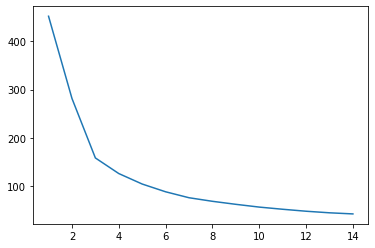

In [46]:
plt.plot(inertias.keys(),inertias.values())

In [47]:
kmeans.set_params(n_clusters=4)
kmeans.fit(data_scaled[['Population','AverageHouseValue','BEA_percap_income']])
zipdata['cluster'] = kmeans.labels_

In [48]:
print(zipdata.groupby('cluster').agg('count')['Population'])
zipdata.groupby('cluster').agg('median')[['AverageHouseValue','Population','over_65_ratio',
                                       'IncomePerHousehold','school_rating','Hosp_count',
                                       'HPI','UE_rate','Zillow_HVF','NumberOfBusinesses']].round(2).sort_values(by='AverageHouseValue')

cluster
0    1141
1    2292
2     760
3    2794
Name: Population, dtype: int64


,AverageHouseValue,Population,over_65_ratio,IncomePerHousehold,school_rating,Hosp_count,HPI,UE_rate,Zillow_HVF,NumberOfBusinesses
cluster,,,,,,,,,,
1,0.0,323.0,0.09,27632.5,5.00,0.0,262.80,4.24,0.0,15.0
2,0.0,0.0,0.00,0.0,5.00,0.0,330.60,4.40,0.0,10.0
3,84700.0,1376.5,0.18,37778.0,5.00,0.0,0.00,4.24,0.0,17.0
0,204200.0,31024.0,0.15,59438.0,5.17,0.0,279.86,4.24,15.3,783.0


In [49]:
px.scatter(zipdata, y = 'BEA_percap_income', x = 'Population', color = 'cluster')

In [50]:
fig = px.parallel_coordinates(zipdata, color = 'cluster', 
                             dimensions = ['cluster', 'Population', 'BEA_percap_income', 
                                            'AverageHouseValue'])
fig.show()

## LABEL TO REDFIN HOUSES

In [51]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [52]:
print(f'shape before merge: {RF.shape}')
RF = RF.merge(zipdata.cluster, how = 'left', left_on = 'zip', right_index=True)
RF.cluster = RF.cluster.astype('object')
print(f'shape after merge: {RF.shape}')

shape before merge: (74717, 21)
shape after merge: (74717, 22)


In [53]:
Cluster_models = {}

lm = LinearRegression()
for clust in RF.cluster.unique():
    X, y = RF[RF.cluster==clust][['SF']], RF[RF.cluster==clust].PRICE
    lm.fit(np.log10(X),np.log10(y))
    Cluster_models[clust] = [lm.intercept_,lm.coef_[0]]

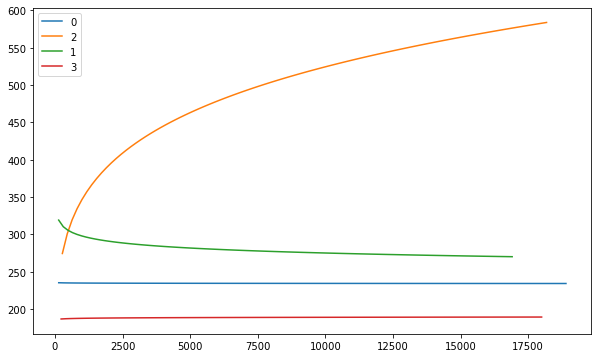

In [54]:
plt.figure(figsize = (10,6))
for clust in RF.cluster.unique():
    SF_range = np.linspace(RF[RF.cluster==clust].SF.min(),RF[RF.cluster==clust].SF.max(),100)
    prx_range = [10**Cluster_models[clust][0] * (each_SF**(Cluster_models[clust][1]-1)) for each_SF in SF_range]    
    plt.plot(SF_range, prx_range, label=clust)
    plt.legend()

In [34]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 8)
X_test rows: (19083, 8)


In [35]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.754380353505014
train R2: 0.7378492575849129
